# ECMF sampling

This notebook contains code to optimally sample star clusters from the Embedded cluster mass function (ECMF)

$$\xi_{\mathrm{ecl}}(M_{\mathrm{ecl}})=k_{\mathrm{ecl}}M_{\mathrm{ecl}}^{-\beta}$$

This code was written using the supplementary.pdf document from the galIMF module ([Yan et al. 2017](https://www.aanda.org/articles/aa/full_html/2017/11/aa30987-17/aa30987-17.html)), which can be found on GitHub under https://github.com/Azeret/galIMF.

## Theoretical background

A similar distribution function as the IMF for stellar masses also exists for star clusters, the **embedded cluster mass function (ECMF)**. **Embedded clusters** are young clusters (< 1 Myr) that are still surrounded by gas and dust from the molecular cloud in which they formed ([Lada & Lada 2003](https://doi.org/10.1146/annurev.astro.41.011802.094844), [Kroupa 2024](https://arxiv.org/abs/2410.07311)).

The canonical embedded cluster mass function follows a powerlaw of the form.
$$
\begin{aligned}
\frac{d N_{\mathrm{ecl}}}{d M_{\mathrm{ecl}}}=\xi_{\mathrm{ecl}} \propto M_{\mathrm{ecl}}^{-\beta}\, ,
\end{aligned}
$$
with $N_{\mathrm{ecl}}$ the number of clusters in the mass range $[M_{\mathrm{ecl}},M_{\mathrm{ecl}}+d M_{\mathrm{ecl}}]$. The power-law index of the canonical ECMF is $\beta \approx 2$ ([Lada & Lada 2003](https://doi.org/10.1146/annurev.astro.41.011802.094844)). 

The ECMF also has been suggested to vary with star formation rate (SFR) of a galaxy by [Weidner et al. (2013)](https://academic.oup.com/mnras/article/436/4/3309/986420) in order to match the variation of galaxy-wide IMFs with SFR observed by [Gunawardhana et al. (2011)](https://academic.oup.com/mnras/article/415/2/1647/1042513). In order to fix the variation of the IMF above $1\,M_{\odot}$, [Weidner et al. (2013)](https://academic.oup.com/mnras/article/436/4/3309/986420) proposed the following variation of the ECMF, if the $\mathrm{SFR} > 1\frac{M_{\odot}}{\mathrm{yr}}$:
$$
\begin{aligned}
	\begin{split}
\beta =
\begin{cases}
     \ 2.00, \quad  &\ \mathrm{SFR} < 1\, M_{\odot}/\mathrm{yr} \\
     \ - 0.106 \log_{10}(\mathrm{SFR}) + 2.00, &\ \mathrm{SFR} \ge 1\, M_{\odot}/\mathrm{yr} \\
\end{cases}
	\end{split}
\end{aligned}
$$

Within the IGIMF Theory, the physical upper limit of the embedded cluster mass is $M_U=10^9\,M_{\odot}$, while the lower limit is $M_L=5\,M_{\odot}$.

## Inputs for the most important ECMF models

There are several ECMF models already implemented from which data can be generated using optimal sampling. In order to set a model, the input **beta_model** needs to be defined.

For a canonical ECMF ($\beta=2$), simply use:

beta_model=0 

For the varying ECMF by [Weidner et al. (2013)](https://academic.oup.com/mnras/article/436/4/3309/986420), typically used within the IGIMF Theory use:

beta_model=2

Also, any positive float can be used as input.

## Three different formulations for ECMF sampling and what they are good for

A case distinction will be made, as the optimal sampling formalism can actually be reformulated such that the mass of the most massive cluster of a population $M_1$ can be taken as input instead of the total stellar mass formed, $M_{\mathrm{tot}}$. 
This is discussed in more detail in the supplementary document.

### Sampling of IGIMFs using the IGIMF Theory (Uses $M_{\mathrm{tot}}$ as input)

This is the standard way in which optimal sampling is performed. It uses the total stellar mass formed $M_{\mathrm{tot}}$, i.e. the sum of stellar masses of all embedded clusters, as input. This mass is typically determined via the mean star formation rate (SFR) over the last 10 Myr, $\bar{\psi}$, as $M_{tot}=\bar{\psi}\times 10 \mathrm{Myr}$. If you want to work with the IGIMF Theory, you should use this formulation.

### Sampling IGIMFs that follow empirical $M_{\mathrm{ecl,max}}-SFR$ relations and investigation of local cIMFs (Uses $M_{\mathrm{tot}}$ and $M_1$ as input)

In order to sample an IGIMF, where the mass of the most massive cluster $M_1$ is determined from an empirical relation between the star formation rate (SFR) and the mass of the most massive young cluster in a galaxy or result, it is possible to give **$M_1$**, as well as **$M_{\mathrm{tot}}$** as input. \
This formulation can be useful to investigate local composite IMFs of star-forming regions to better understand star-formation on a sub-galactic scale. \
Therefore it could also give insights towards the development of a sub-galactic extension to the IGIMF framework. Though, one has to be cautios on how to interpret the results in regards to the IGIMF Theory (see, supplementary documentation).

### Sampling of composite IMFs (Uses $M_1$ as input)

Another formulation that can be interesting especially for the study of sub-galactic systems, ECMFs can also be drawn, where only the mass of the most massive cluster $M_1$ is known. This could be useful for modeling e.g. star-forming regions, where **$M_{\mathrm{tot}}$** is unknown. **$M_{\mathrm{tot}}$** will then depend on $M_1$ and the ECMF model.\
This formulation is likely the most unfit for practical use, as the measurement of cluster masses on local scales is subject to large uncertainties compared to the relative uncertainties on galaxy-wide scales.

## Necessary functions to initialize

For most uses, the two mentioned models should be sufficient, but of course more models can be added freely to the function below. The algorithm is already modified such that also a possible dependence of the ECMF on metallicity could be investigated, but for the already implemented models the input M_over_H can simply be set to zero.

In [6]:
from scipy.optimize import root_scalar
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate

## beta-model function imported from galimf.py
def function_beta_change(beta_model, SFR, M_over_H):
    if (beta_model == 0):
        default_beta = 2.00000001
        return default_beta
    elif (beta_model == 1):
        beta_change = -0.106 * math.log(SFR, 10) + 2.000001 #+ 0.5*M_over_H
        if beta_change < 1.5:
            beta_change = 1.5
        elif beta_change > 2.5:
            beta_change = 2.5
        # print("ECMF-beta =", beta_change)
        return beta_change
    elif (beta_model == 2):
        ### changed so there, don't occur any math errors
        if SFR > 1:
            beta_change = -0.106 * math.log(SFR, 10) + 2.00000001
        else:
            beta_change = 2.0000001
        return beta_change
    elif (beta_model == 3):
        beta_change = 1.4
        return beta_change
    else:
        return beta_model

## MLE for powerlaws

We are also initializing a maximum likelihood estimator (MLE) for powerlaws to check, that the slopes of the drawn samples are actually close to the theoretical values. This powerlaw MLE is based on [Maschberger & Kroupa (2009)](https://academic.oup.com/mnras/article/395/2/931/1747409).

It returns the estimate and its standard error as: (estimate, error estimate)

In [7]:
def MLE_with_std(data):

    Y=np.min(data)
    Z=np.max(data)
    T=np.sum(np.log(data))
    n=len(data)

    ## Does this really determine the exponent I look for?
    def Determinator(alpha_ML):  
        eq1 = -n/(1-alpha_ML)
        eq2 = n*(Z**(1-alpha_ML)*np.log(Z)-Y**(1-alpha_ML)*np.log(Y))/(Z**(1-alpha_ML)-Y**(1-alpha_ML))-T
        return eq1+eq2
        
    sol = root_scalar(Determinator, bracket=[-30.0, 0.999*30.0])
    slope = sol.root
    slope_unbiased=(n)/(n-2)*(slope-1)+1 ## According to Maschberger& Kroupa (2009)


    Fisher_information=n*(slope_unbiased/(1-slope_unbiased)**2+(Y**(1-slope_unbiased)*Z**(1-slope_unbiased)*((np.log(Z)-np.log(Y))**2))/(Z**(1-slope_unbiased)-Y**(1-slope_unbiased))**2)

    Variance=1/(n*Fisher_information)
    SE=np.sqrt(Variance) ### This is the standard error!! Not the standard deviation!
    std=np.sqrt(1/Fisher_information)


    return slope_unbiased, std

## ECMF sampling when the total stellar mass formed, $M_{\mathrm{tot}}$, is known.

This algorithm is the standard ECMF sampling for the IGIMF Theory.\
The total mass $M_{\mathrm{tot}}$ is determined via the mean star formation rate over the last 10 Myr, $\bar{\psi}$, as $M_{\mathrm{tot}}=\bar{\psi}\times 10\, \mathrm{Myr}$. \
The mass of the most massive cluster drawn $M_1$ depends on $M_{\mathrm{tot}}$. 

It can be used to draw the galaxy-wide cluster population within the IGIMF Theory framework. 

In [13]:
### Sampling from the ECMF
### The ECMF is the Embedded Cluster Mass Function, which is the mass function of star clusters

### First some functions are defined that are needed to sample from the ECMF

### Find upper integration limit m_ecl_max for the embedded cluster mass function
### using only the total mass of the region (M_tot) as input

### Find Mecl,max for beta=2

def find_m_ecl_max_beq2_M_tot(M_tot):
    M_ecl_L = 5.0  # embedded cluster mass lower limit [solar mass]
    M_ecl_U = 1e9  # embdedded cluster mass upper limit [solar mass]

    I_ecl = 1.0 # normalization factor for the embedded cluster mass function

    def M_ecl_max(M_ecl_max):
        M_theo=I_ecl*(math.log(M_ecl_max)-math.log(M_ecl_L))/(M_ecl_max**(-1)-M_ecl_U**(-1))
        return M_tot-M_theo
    
    sol = root_scalar(M_ecl_max, bracket=[M_ecl_L, 0.9999*M_ecl_U])
    m_ecl_max = sol.root
    return m_ecl_max


### Find Mecl,max for beta unequal 2

def find_m_ecl_max_buneq2_M_tot(M_tot, beta_model, SFR, M_over_H):
    M_ecl_L = 5.0  # embedded cluster mass lower limit [solar mass]
    M_ecl_U = 1e9  # embdedded cluster mass upper limit [solar mass]

    I_ecl = 1.0 # normalization factor for the embedded cluster mass function

    beta=function_beta_change(beta_model, SFR, M_over_H)

    def M_ecl_max(M_ecl_max):
        M_theo=I_ecl*(1-beta)/(2-beta)*(M_ecl_max**(2-beta)-M_ecl_L**(2-beta))/(M_ecl_U**(1-beta)-M_ecl_max**(1-beta))
        return M_tot-M_theo
    
    sol = root_scalar(M_ecl_max, bracket=[M_ecl_L, 0.9999*M_ecl_U])
    m_ecl_max = sol.root
    return m_ecl_max


### ECMF function*m with prefactor. Can be used to determine Masses M_ecl_i
def model_ecmf_m(m_ecl, beta_model, SFR, M_over_H, kecl):
    M_ecl_L = 5.0  # star mass lower limit [solar mass]
    M_ecl_U = 1e9  # star mass upper limit [solar mass]

    ### kecl is the prefactor for the ECMF
    beta=function_beta_change(beta_model, SFR, M_over_H)

    if m_ecl < M_ecl_L:
        return 0
    if M_ecl_L < m_ecl < M_ecl_U:
        return kecl*m_ecl**(1-beta)
    if m_ecl > M_ecl_U:
        return 0
    
########################################################################################

### Drawing from ecmf with M_tot as an input.

### drawing from ecmf with M_tot as an input

def draw_ecmf_M_tot(M_tot,beta_model,SFR,M_over_H):
    M_ecl_L = 5.0  # star mass lower limit [solar mass]
    M_ecl_U = 1e9  # star mass upper limit [solar mass]
    I_ecl=1. #normalization factor in the Optimal Sampling condition equation (says that integral from m_ecl_max to M_ecl_U of IMF is equal to 1; one star in that mass range)
    ## I_str = scipy.integrate.quad(function_IMF(m), M_max, M_str_U)[0]

    ## slope beta of the ECMF, dependent on model
    beta=function_beta_change(beta_model, SFR, M_over_H)


    ## find m_ecl_max by using root_scalar
    ## m_ecl_max=m_1 is the upper integration limit for the most massive cluster in a region
    ## It is NOT the mass of the most massive cluster!

    ## upper integration limit for region/galaxy of mass M_tot is found by using the Optimal Sampling condition

    ## distinguish between cases of beta being equal to 2 or unequal to 2
    ## also the normalization constant of the ECMF, kecl, is determined here 

    if beta_model==0:
        m_ecl_max=find_m_ecl_max_beq2_M_tot(M_tot)
        kecl=I_ecl*(1-beta)/(M_ecl_U**(1-beta)-m_ecl_max**(1-beta))

    elif beta_model!=0:
        
        m_ecl_max=find_m_ecl_max_buneq2_M_tot(M_tot, beta_model, SFR, M_over_H)
        kecl=I_ecl*(1-beta)/(M_ecl_U**(1-beta)-m_ecl_max**(1-beta))

    m_i=m_ecl_max


    ### m_i and m_i+1 are not the cluster masses, but only the upper and lower limits of the mass intervals
    ### from which the masses M_i are drawn

    ### draw all other clusters with the conditions stated in supplementary document
    ### m_i_array is the array of all integration limits for the clusters in the region
    m_i_array = np.array([])
    m_i_array=np.append(m_i_array,m_i)

    ### Array for all Masses M_i that are drawn with help of the integration limits m_i
    M_i_array = np.array([])

    ### Masses M_i are determined by integral from m_i+1 to m_i over m*ECMF(m)

    ## let loop run while the lower integration limit is larger than M_str_L
    while m_i > M_ecl_L:
        

        ## General idea: m_i is known, m_i+1 is ought to be found
        ## For this the formulas given in the galIMF modules supplementary.pdf file can be used
        ## One can calculate m_i+1 with the conditions stated in the supplementary document

        ## Code calculates the m_i+1 for given conditions on m_i

        m_i_1=(m_i**(1-beta)-(1-beta)/(kecl))**(1/(1-beta))

        if M_ecl_L < m_i_1 < m_i < M_ecl_U:
            m_i_array=np.append(m_i_array,m_i_1)
            ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
            M_i= (scipy.integrate.quad(model_ecmf_m, m_i_1, m_i, args=(beta_model, SFR, M_over_H, kecl))[0])
            M_i_array=np.append(M_i_array,M_i)
            # print(M_i)
            m_i=m_i_1

        elif m_i_1 < M_ecl_L:
                print("All clusters drawn")
                break

    ### Total mass drawn from the ECMF
    totalmass = np.sum(M_i_array)
    ### Number of clusters drawn from the ECMF
    num_clusters = len(M_i_array)

    ## return the arrays of integration limits and masses, the total mass and the number of clusters
    return m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max

## Outputs
The sampling function in its current state returns:
- m_i_array: The array of integral boundaries from which the cluster masses are drawn
- M_i_array: The array of drawn cluster masses
- totalmass: The sum of the drawn cluster masses
- num_clusters: The number of drawn clusters
- kecl: The normalization constant of the ECMF
- beta: The input ECMF slope
- m_ecl_max: The upper integration bound used for the sampling

Those outputs can of course be modified, depending on the desired use.

## Example

In [17]:
## Define an ECMF function

def ECMF(Mecl, kecl, beta, mecl_max):
    if 5 < Mecl < mecl_max:
        ecmf=kecl*Mecl**(-beta)
    else:
        ecmf=0
    return ecmf

All clusters drawn
The total sum of drawn clusters is: 99996.01057296206
The sample contains 2548 clusters
The most massive cluster has a mass of M_1 = 8836.847168190507
From integrating over the ECMF, it should contain 2548.7988110526985 clusters
The ECMF slope of the sample is: 1.9997773956704892 +/- 0.013896179343081246
The input ECMF slope for the drawn sample is: 2.00000001


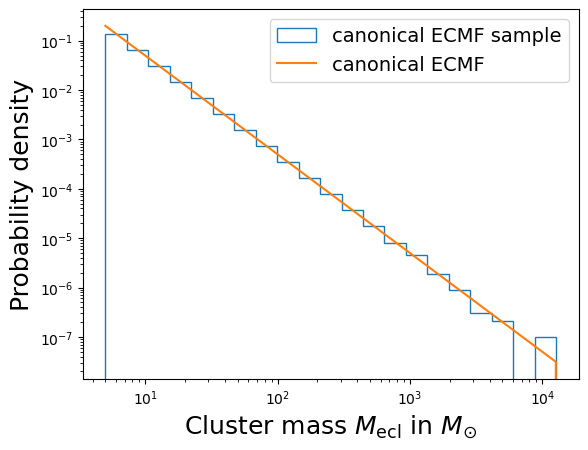

In [47]:
## Sample from a canonical ECMF (beta=2)
SFR=0.01
M_tot=SFR*10**7
beta_model=0
M_over_H=0

m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max = draw_ecmf_M_tot(M_tot,beta_model,SFR,M_over_H)

logbins=np.logspace(np.log10(np.min(m_i_array)),np.log10(np.max(m_i_array)), int(len(m_i_array)**(2/5)-1))
plt.hist(M_i_array, bins=logbins, density=True, label='canonical ECMF sample', histtype='step')
plt.xscale('log')
plt.yscale('log')

x=np.logspace(np.log10(5),np.log10(m_ecl_max),1000)
i=0
ECMF_can=np.array([])
while i<len(x):
    ECMF_can=np.append(ECMF_can, ECMF(x[i], kecl, 2, m_ecl_max)/len(M_i_array))
    i=i+1

print('The total sum of drawn clusters is:', totalmass)
print('The sample contains', len(M_i_array), 'clusters')
print('The most massive cluster has a mass of M_1 =', M_i_array[0])

print('From integrating over the ECMF, it should contain', scipy.integrate.quad(ECMF, 5, m_ecl_max, args=(kecl, 2, m_ecl_max))[0], 'clusters')
print(r'The ECMF slope of the sample is:',MLE_with_std(M_i_array)[0], '+/-', MLE_with_std(M_i_array)[1])
print(r'The input ECMF slope for the drawn sample is:', beta)

plt.loglog(x, ECMF_can, label='canonical ECMF')
plt.xlabel(r'Cluster mass $M_{\mathrm{ecl}}$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

All clusters drawn
The total sum of drawn clusters is: 999995.827678661
The sample contains 453 clusters
The most massive cluster has a mass of M_1 = 493205.4767414536
From integrating over the ECMF, it should contain 453.8329362202825 clusters
The ECMF slope of the sample is: 1.5001939272867373 +/- 0.018543559581098046
The input ECMF slope for the drawn sample is: 1.5


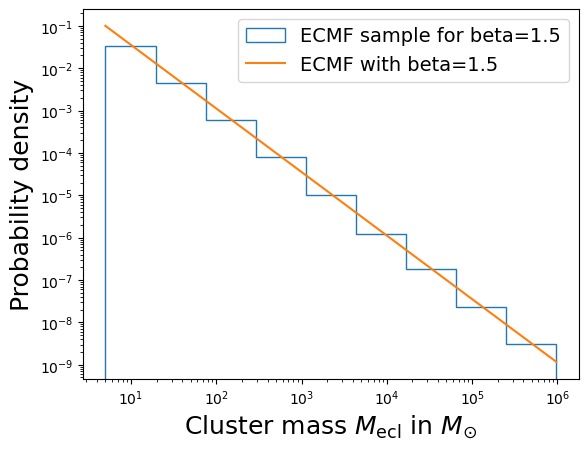

In [48]:
## Sample from a ECMF with beta=1.5
SFR=0.1
M_tot=SFR*10**7
beta_model=1.5
M_over_H=0

m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max = draw_ecmf_M_tot(M_tot,beta_model,SFR,M_over_H)

logbins=np.logspace(np.log10(np.min(m_i_array)),np.log10(np.max(m_i_array)), int(len(m_i_array)**(2/5)-1))
plt.hist(M_i_array, bins=logbins, density=True, label='ECMF sample for beta=1.5', histtype='step')
plt.xscale('log')
plt.yscale('log')

x=np.logspace(np.log10(5),np.log10(m_ecl_max),1000)
i=0
ECMF_can=np.array([])
while i<len(x):
    ECMF_can=np.append(ECMF_can, ECMF(x[i], kecl, 1.5, m_ecl_max)/len(M_i_array))
    i=i+1

print('The total sum of drawn clusters is:', totalmass)
print('The sample contains', len(M_i_array), 'clusters')
print('The most massive cluster has a mass of M_1 =', M_i_array[0])

print('From integrating over the ECMF, it should contain', scipy.integrate.quad(ECMF, 5, m_ecl_max, args=(kecl, 1.5, m_ecl_max))[0], 'clusters')
print(r'The ECMF slope of the sample is:',MLE_with_std(M_i_array)[0], '+/-', MLE_with_std(M_i_array)[1])
print(r'The input ECMF slope for the drawn sample is:', beta)

plt.loglog(x, ECMF_can, label='ECMF with beta=1.5')
plt.xlabel(r'Cluster mass $M_{\mathrm{ecl}}$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

## Drawing the ECMF if $M_{\mathrm{tot}}$ and also the mass of the most massive cluster $M_1$ is known

This presents a reformulation of the use of the variable $I_{\mathrm{ecl}}$ which has no real physical meaning but can be varied in order to generate samples where the mass of the most massive cluster matches observations. The algorithm here uses the same logic, but in a more direct way, defining instead the mass of the most massive cluster mass $M_1$ as an additional input. This is equivalent to changing $I_{\mathrm{ecl}}$, but is a little easier to handle in applications.

This algorithm can be useful for the study of composite IMFs of star-forming regions. Varying IMFs can allow for example top-heavy IMFs in strongly star-forming regions. Also, it can be used to investigate e.g. the form of local ECMFs and their dependence on environment. \
Lastly, it could be used to try to find a new empirical ECMF function, where fits to galaxy-wide IMFs are made using empirical fits to $M_1-SFR$ relations as starting point.

In [49]:
########################################################################################

### Drawing from the ecmf with M_1 and M_tot as input

## drawing M_ecl_max for the case that beta is unequal 2

def find_m_ecl_max_buneq2_M1_Mtot(M_1,M_tot,beta):
    M_ecl_L = 5.0  # embedded cluster mass lower limit [solar mass]
    M_ecl_U = 1e9  # embdedded cluster mass upper limit [solar mass]


    def M_ecl_max(M_ecl_max):
        
        ### have to plug in kecl directly to avoid root_scalar failing for small values
        eq1=M_ecl_max**(2.0-beta)-((M_ecl_max**(2.0-beta)-M_ecl_L**(2.0-beta))/M_tot)*(M_1)
        #eq2=(M_ecl_max**(1-beta)-(1-beta)/(kecl))**((2-beta)/(1-beta))
        eq2=(M_ecl_max**(1.0-beta)-(1.0-beta)/(2.0-beta)*(M_ecl_max**(2.0-beta)-M_ecl_L**(2.0-beta))/(M_tot))**((2.0-beta)/(1.0-beta))
        return eq1-eq2
    
    sol = root_scalar(M_ecl_max, bracket=[M_ecl_L*1.0001, 0.9999*M_ecl_U])
    m_ecl_max = sol.root
    return m_ecl_max

## drawing M_ecl_max for the case that beta is equal 2

def find_m_ecl_max_beq2_M1_Mtot(M_1,M_tot,beta):
    M_ecl_L = 5.0  # embedded cluster mass lower limit [solar mass]
    M_ecl_U = 1e9  # embdedded cluster mass upper limit [solar mass]


    def M_ecl_max(M_ecl_max):
        
        ### have to plug in kecl directly to avoid root_scalar failing for small values
        eq1=M_ecl_max*(M_ecl_max/M_ecl_L)**(-M_1/M_tot)
        eq2=(M_ecl_max**(1.0-beta)+(beta-1.0)/(M_tot)*np.log(M_ecl_max/M_ecl_L))**(1.0/(1.0-beta))
        return eq1-eq2
    
    sol = root_scalar(M_ecl_max, bracket=[M_ecl_L*1.0001, 0.9999*M_ecl_U])
    m_ecl_max = sol.root
    return m_ecl_max

########################################################################################

### drawing from ecmf with M_1 and M_tot as an input. 
### M_1 is the mass of the most massive cluster in a region

def draw_ecmf_M_1_Mtot(M_1,M_tot,beta_model,SFR,M_over_H):

    ## check if M_1 is larger than 5 solar masses
    if M_1 < 5:
        print("M_1 is too small. Please enter a value larger than 5.0 solar masses.")
        return
    
    ## More than one cluster can only be drawn for M_1 > 10.5 solar masses (approximately)

    ## lower and upper limits for the star mass
    M_ecl_L = 5.0  # star mass lower limit [solar mass]
    M_ecl_U = 1e9  # star mass upper limit [solar mass]
    I_ecl=1. #normalization factor in the Optimal Sampling condition equation (says that integral from m_ecl_max to M_ecl_U of IMF is equal to 1; one star in that mass range)

    ## slope beta of the ECMF, dependent on model
    beta=function_beta_change(beta_model, SFR, M_over_H)

    ## find m_ecl_max by using root_scalar
    ## m_ecl_max=m_1 is the upper integration limit for the most massive cluster in a region
    ## It is NOT the mass of the most massive cluster!

    ## upper integration limit for region/galaxy of mass M_tot is found by using the Optimal Sampling condition

    ## distinguish between cases of beta being equal to 2 or unequal to 2

    if beta_model==0:
        m_ecl_max=find_m_ecl_max_beq2_M1_Mtot(M_1,M_tot,beta)
        kecl=M_tot/(np.log(m_ecl_max)-np.log(M_ecl_L))


    elif beta_model==1:
        print('beta=1 is not implemented yet')

    elif beta_model==2 and SFR>1:
        
        m_ecl_max=find_m_ecl_max_buneq2_M1_Mtot(M_1,M_tot, beta)
        kecl=(2.0-beta)*M_tot/(m_ecl_max**(2.0-beta)-M_ecl_L**(2.0-beta))

    elif beta_model==2 and SFR<=1:
        
        m_ecl_max=find_m_ecl_max_beq2_M1_Mtot(M_1,M_tot,beta)
        kecl=M_tot/(np.log(m_ecl_max)-np.log(M_ecl_L))

    elif beta_model==3:

        m_ecl_max=find_m_ecl_max_buneq2_M1_Mtot(M_1, M_tot, beta)
        kecl=(2.0-beta)*M_tot/(m_ecl_max**(2.0-beta)-M_ecl_L**(2.0-beta))

    elif beta_model!=0 and beta_model!=1 and beta_model!=2 and beta_model!=3:

        m_ecl_max=find_m_ecl_max_buneq2_M1_Mtot(M_1, M_tot, beta)
        kecl=(2.0-beta)*M_tot/(m_ecl_max**(2.0-beta)-M_ecl_L**(2.0-beta))


    m_i=m_ecl_max


    ### m_i and m_i+1 are not the cluster masses, but only the upper and lower limits of the mass intervals
    ### from which the masses M_i are drawn

    ### draw all other clusters with the conditions stated in supplementary document
    ### m_i_array is the array of all integration limits for the clusters in the region
    m_i_array = np.array([])
    m_i_array=np.append(m_i_array,m_i)


    ### Array for all Masses M_i that are drawn with help of the integration limits m_i
    M_i_array = np.array([])

    ### Masses M_i are determined by integral from m_i+1 to m_i over m*ECMF(m)

    ## let loop run while the lower integration limit is larger than M_str_L
    while m_i > M_ecl_L:

        ## Code calculates the m_i+1 for given conditions on m_i

        m_i_1=(m_i**(1-beta)-(1-beta)/(kecl))**(1/(1-beta))

        if M_ecl_L < m_i_1 < m_i < M_ecl_U:
            m_i_array=np.append(m_i_array,m_i_1)
            ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
            M_i= (scipy.integrate.quad(model_ecmf_m, m_i_1, m_i, args=(beta_model, SFR, M_over_H, kecl))[0])
            M_i_array=np.append(M_i_array,M_i)
            m_i=m_i_1

        elif m_i_1 < M_ecl_L:
                print("All clusters drawn")
                break

    ### Total mass drawn from the ECMF
    totalmass = np.sum(M_i_array)
    ### Number of clusters drawn from the ECMF
    num_clusters = len(M_i_array)

    ## return the arrays of integration limits and masses, the total mass and the number of clusters
    return m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max

All clusters drawn
The total sum of drawn clusters is: 99999.31679800883
The sample contains 2490 clusters
The most massive cluster has a mass of M_1 = 9999.999076294222
From integrating over the ECMF, it should contain 2490.13557683044 clusters
The ECMF slope of the sample is: 1.9997691614482647 +/- 0.014066568597496493
The input ECMF slope for the drawn sample is: 2.00000001


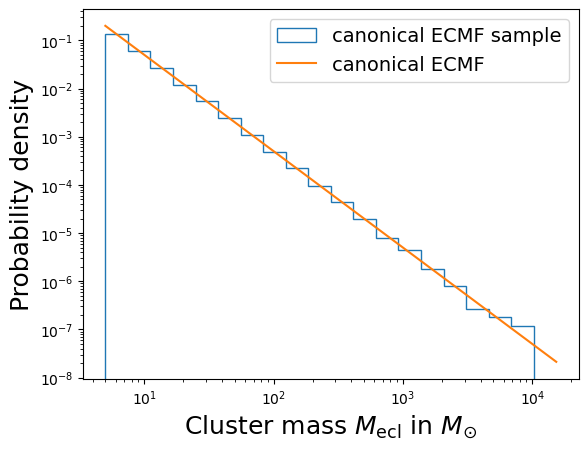

In [50]:
## Sample from a canonical ECMF (beta=2)
SFR=0.01
M_tot=SFR*10**7 # Msolar
beta_model=0
M_over_H=0
M_1= 10000 # Msolar

m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max = draw_ecmf_M_1_Mtot(M_1,M_tot,beta_model,SFR,M_over_H)

logbins=np.logspace(np.log10(np.min(m_i_array)),np.log10(np.max(m_i_array)), int(len(m_i_array)**(2/5)-1))
plt.hist(M_i_array, bins=logbins, density=True, label='canonical ECMF sample', histtype='step')
plt.xscale('log')
plt.yscale('log')

x=np.logspace(np.log10(5),np.log10(m_ecl_max),1000)
i=0
ECMF_can=np.array([])
while i<len(x):
    ECMF_can=np.append(ECMF_can, ECMF(x[i], kecl, 2, m_ecl_max)/len(M_i_array))
    i=i+1

print('The total sum of drawn clusters is:', totalmass)
print('The sample contains', len(M_i_array), 'clusters')
print('The most massive cluster has a mass of M_1 =', M_i_array[0])

print('From integrating over the ECMF, it should contain', scipy.integrate.quad(ECMF, 5, m_ecl_max, args=(kecl, 2, m_ecl_max))[0], 'clusters')
print(r'The ECMF slope of the sample is:',MLE_with_std(M_i_array)[0], '+/-', MLE_with_std(M_i_array)[1])
print(r'The input ECMF slope for the drawn sample is:', beta)

plt.loglog(x, ECMF_can, label='canonical ECMF')
plt.xlabel(r'Cluster mass $M_{\mathrm{ecl}}$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

All clusters drawn
The total sum of drawn clusters is: 999998.9043455092
The sample contains 4450 clusters
The most massive cluster has a mass of M_1 = 10000.000000000095
From integrating over the ECMF, it should contain 4450.219120349046 clusters
The ECMF slope of the sample is: 1.5000575207145168 +/- 0.005529388567995267
The input ECMF slope for the drawn sample is: 1.5


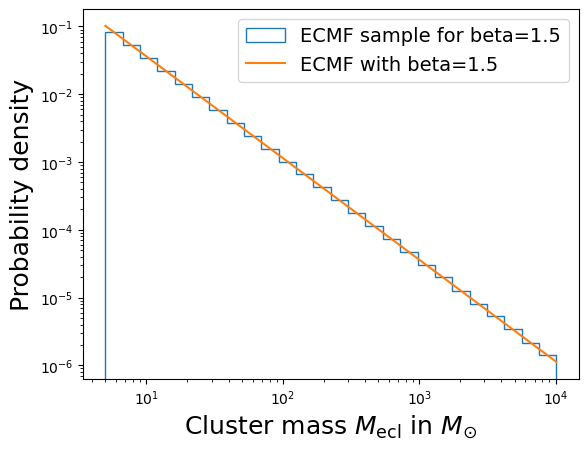

In [51]:
## Sample from a ECMF with beta=1.5
SFR=0.1
M_tot=SFR*10**7 # Msolar
beta_model=1.5
M_over_H=0
M_1= 10000 # Msolar

m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max = draw_ecmf_M_1_Mtot(M_1,M_tot,beta_model,SFR,M_over_H)

logbins=np.logspace(np.log10(np.min(m_i_array)),np.log10(np.max(m_i_array)), int(len(m_i_array)**(2/5)-1))
plt.hist(M_i_array, bins=logbins, density=True, label='ECMF sample for beta=1.5', histtype='step')
plt.xscale('log')
plt.yscale('log')

x=np.logspace(np.log10(5),np.log10(m_ecl_max),1000)
i=0
ECMF_can=np.array([])
while i<len(x):
    ECMF_can=np.append(ECMF_can, ECMF(x[i], kecl, 1.5, m_ecl_max)/len(M_i_array))
    i=i+1

print('The total sum of drawn clusters is:', totalmass)
print('The sample contains', len(M_i_array), 'clusters')
print('The most massive cluster has a mass of M_1 =', M_i_array[0])

print('From integrating over the ECMF, it should contain', scipy.integrate.quad(ECMF, 5, m_ecl_max, args=(kecl, 1.5, m_ecl_max))[0], 'clusters')
print(r'The ECMF slope of the sample is:',MLE_with_std(M_i_array)[0], '+/-', MLE_with_std(M_i_array)[1])
print(r'The input ECMF slope for the drawn sample is:', beta)

plt.loglog(x, ECMF_can, label='ECMF with beta=1.5')
plt.xlabel(r'Cluster mass $M_{\mathrm{ecl}}$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

## Drawing the ECMF, when only the mass of the most massive cluster $M_1$ is known, but no total mass $M_{tot}$

This is the last formulation, that uses the most massive cluster mass $M_1$ as input value instead of the total mass of the region or galaxy, $M_{\mathrm{tot}}$. Here, it will serve as proof of concept that the choice of either $M_{\mathrm{tot}}$ or $M_1$ as input is equivalent to the optimal sampling algorithm.

This case may be useful for sub-galactic systems, e.g. star-forming regions, where the most massive cluster in a certain region is known, as well as the local ECMF slope, but the mass of the region is uncertain. It could also be used to investigate how the physical upper limit $M_U$, which is closely connected to $I_{\mathrm{ecl}}$, could be modified for sub-galactic regions to fit local relations between total mass and most massive cluster mass.

In [52]:
### Find upper integration limit m_ecl_max for the embedded cluster mass function
### Needs the mass of the most massive cluster M_1 as input

### Find Mecl,max for the case of beta=2

def find_m_ecl_max_beq2_M1(M_1):
    M_ecl_L = 5.0  # embedded cluster mass lower limit [solar mass]
    M_ecl_U = 1e9  # embdedded cluster mass upper limit [solar mass]

    I_ecl = 1.0 # normalization factor for the embedded cluster mass function

    def M_ecl_max(M_ecl_max):
        ## equation 8
        kecl=I_ecl/(M_ecl_max**(-1)-M_ecl_U**(-1))
        ## equation 7
        eq1=M_ecl_max*np.exp(-M_1/kecl)
        ## equation 9
        eq2=(M_ecl_max**(-1)+1/kecl)**(-1)
        return eq1-eq2
    
    sol = root_scalar(M_ecl_max, bracket=[M_ecl_L, 0.9999*M_ecl_U])
    m_ecl_max = sol.root
    return m_ecl_max


### Find Mecl,max for beta unequal 2

def find_m_ecl_max_buneq2_M1(M_1,beta):
    M_ecl_L = 5.0  # embedded cluster mass lower limit [solar mass]
    M_ecl_U = 1e9  # embdedded cluster mass upper limit [solar mass]

    I_ecl = 1.0 # normalization factor for the embedded cluster mass function

    def M_ecl_max(M_ecl_max):  
        ### have to plug in kecl directly to avoid root_scalar failing for small values
        ## equation 1 from my notes
        eq1=(M_ecl_max**(2.0-beta)-((2.0-beta)/(I_ecl*(1.0-beta)))*(M_1)*(M_ecl_U**(1.0-beta)-M_ecl_max**(1.0-beta)))
        ## equation 3 from my notes
        eq2=(M_ecl_max**(1-beta)-(1-beta)/(I_ecl*(1.0-beta)/(M_ecl_U**(1.0-beta)-M_ecl_max**(1.0-beta))))**((2-beta)/(1-beta))
        return eq1-eq2
    
    sol = root_scalar(M_ecl_max, bracket=[M_ecl_L, 0.9999*M_ecl_U])
    m_ecl_max = sol.root
    return m_ecl_max

### ECMF function*m with normalization kecl. Can be used to determine Masses M_ecl_i
def model_ecmf_m(m_ecl, beta_model, SFR, M_over_H, kecl):
    M_ecl_L = 5.0  # star mass lower limit [solar mass]
    M_ecl_U = 1e9  # star mass upper limit [solar mass]
    
    ### kecl is the normalization for the ECMF
    beta=function_beta_change(beta_model, SFR, M_over_H)

    if m_ecl < M_ecl_L:
        return 0
    if M_ecl_L < m_ecl < M_ecl_U:
        return kecl*m_ecl**(1-beta)
    if m_ecl > M_ecl_U:
        return 0
    
########################################################################################

### Drawing from ecmf with M_1 as an input. 
### M_1 is the mass of the most massive cluster in a region

def draw_ecmf_M_1(M_1,beta_model,SFR,M_over_H):

    ## check if M_1 is larger than 5 solar masses
    if M_1 < 5:
        print("M_1 is too small. Please enter a value larger than 5.0 solar masses.")
        return
    
    ## More than one cluster can only be drawn for M_1 > 10.5 solar masses (approximately)

    ## lower and upper limits for the star mass
    M_ecl_L = 5.0  # star mass lower limit [solar mass]
    M_ecl_U = 1e9  # star mass upper limit [solar mass]
    I_ecl=1. #normalization factor in the Optimal Sampling condition equation (says that integral from m_ecl_max to M_ecl_U of IMF is equal to 1; one star in that mass range)

    ## slope beta of the ECMF, dependent on model
    beta=function_beta_change(beta_model, SFR, M_over_H)


    ## find m_ecl_max by using root_scalar
    ## m_ecl_max=m_1 is the upper integration limit for the most massive cluster in a region
    ## It is NOT the mass of the most massive cluster!

    ## upper integration limit for region/galaxy of mass M_tot is found by using the Optimal Sampling condition

    ## distinguish between cases of beta being equal to 2 or unequal to 2

    if beta_model==0:
        
        m_ecl_max=find_m_ecl_max_beq2_M1(M_1)
        kecl=I_ecl*(1.0-beta)/(M_ecl_U**(1.0-beta)-m_ecl_max**(1.0-beta))

        M_tot_theo=kecl*(np.log(m_ecl_max)-np.log(M_ecl_L))
        #print('M_tot,theo=',M_tot_theo)

    elif beta_model==1:
        print('beta=1 is not implemented yet')

    elif beta_model==2 and SFR>1:
        
        m_ecl_max=find_m_ecl_max_buneq2_M1(M_1, beta)
        kecl=I_ecl*(1.0-beta)/(M_ecl_U**(1-beta)-m_ecl_max**(1.0-beta))

        M_tot_theo=kecl/(2.0-beta)*(m_ecl_max**(2.0-beta)-M_ecl_L**(2.0-beta))
        print('M_tot,theo=',M_tot_theo)

    elif beta_model==2 and SFR<=1:
        
        m_ecl_max=find_m_ecl_max_beq2_M1(M_1)
        kecl=I_ecl*(1.0-beta)/(M_ecl_U**(1.0-beta)-m_ecl_max**(1.0-beta))

        M_tot_theo=kecl*(np.log(m_ecl_max)-np.log(M_ecl_L))
        print('M_tot,theo=',M_tot_theo)

    elif beta_model==3:
        
        m_ecl_max=find_m_ecl_max_buneq2_M1(M_1, beta)
        kecl=I_ecl*(1.0-beta)/(M_ecl_U**(1-beta)-m_ecl_max**(1.0-beta))

        M_tot_theo=kecl/(2.0-beta)*(m_ecl_max**(2.0-beta)-M_ecl_L**(2.0-beta))
        print('M_tot,theo=',M_tot_theo)

    elif beta_model!=0 and beta_model!=1 and beta_model!=2 and beta_model!=3:
        
        m_ecl_max=find_m_ecl_max_buneq2_M1(M_1, beta)
        kecl=I_ecl*(1.0-beta)/(M_ecl_U**(1-beta)-m_ecl_max**(1.0-beta))

        M_tot_theo=kecl/(2.0-beta)*(m_ecl_max**(2.0-beta)-M_ecl_L**(2.0-beta))
        print('M_tot,theo=',M_tot_theo)


    #define determined upper integration limit m_ecl_max as the variable m_i
    m_i=m_ecl_max


    ### m_i and m_i+1 are not the cluster masses, but only the upper and lower limits of the mass intervals
    ### from which the masses M_i are drawn

    ### draw all other clusters with the conditions stated in supplementary document
    ### m_i_array is the array of all integration limits for the clusters in the region
    m_i_array = np.array([])
    m_i_array=np.append(m_i_array,m_i)

    ### Array for all Masses M_i that are drawn with help of the integration limits m_i
    M_i_array = np.array([])

    ### Masses M_i are determined by integral from m_i+1 to m_i over m*ECMF(m)

    ## let loop run while the lower integration limit is larger than M_str_L
    while m_i > M_ecl_L:

        ## Code calculates the m_i+1 for given conditions on m_i
        ## From the m_i+1, the mass M_i can be determined by integrating the ECMF from m_i+1 to m_i

        m_i_1=(m_i**(1-beta)-(1-beta)/(kecl))**(1/(1-beta))

        if M_ecl_L < m_i_1 < m_i < M_ecl_U:
            m_i_array=np.append(m_i_array,m_i_1)
            ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
            M_i= (scipy.integrate.quad(model_ecmf_m, m_i_1, m_i, args=(beta_model, SFR, M_over_H, kecl))[0])
            M_i_array=np.append(M_i_array,M_i)
            m_i=m_i_1

        elif m_i_1 < M_ecl_L:
                print("All clusters drawn")
                break

    ### Total mass drawn from the ECMF
    totalmass = np.sum(M_i_array)
    ### Number of clusters drawn from the ECMF
    num_clusters = len(M_i_array)

    ## return the arrays of integration limits and masses, the total mass and the number of clusters
    return m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max

All clusters drawn
The total sum of drawn clusters is: 99996.01091948143
The sample contains 2548 clusters
The most massive cluster has a mass of M_1 = 8836.847198812862
From integrating over the ECMF, it should contain 2548.798819888606 clusters
The ECMF slope of the sample is: 1.9997773956702103 +/- 0.013896179343078177
The input ECMF slope for the drawn sample is: 2.00000001


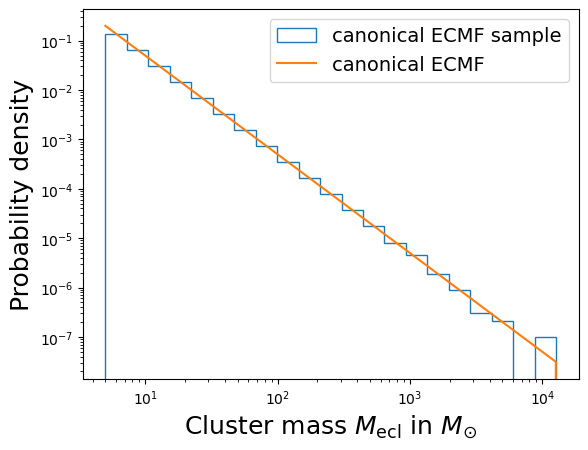

In [53]:
## Sample from a canonical ECMF (beta=2)
#SFR=0.01
#M_tot=SFR*10**7
beta_model=0
M_over_H=0
## taking the mass drawn from the most massive cluster from the draw_ecmf_M_tot function for M_tot=100000
## If the code is correct, the sample should have an M_tot=100000 as well
M_1= 8836.847168190507 # Msolar

m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max = draw_ecmf_M_1(M_1,beta_model,SFR,M_over_H)

logbins=np.logspace(np.log10(np.min(m_i_array)),np.log10(np.max(m_i_array)), int(len(m_i_array)**(2/5)-1))
plt.hist(M_i_array, bins=logbins, density=True, label='canonical ECMF sample', histtype='step')
plt.xscale('log')
plt.yscale('log')

x=np.logspace(np.log10(5),np.log10(m_ecl_max),1000)
i=0
ECMF_can=np.array([])
while i<len(x):
    ECMF_can=np.append(ECMF_can, ECMF(x[i], kecl, 2, m_ecl_max)/len(M_i_array))
    i=i+1

print('The total sum of drawn clusters is:', totalmass)
print('The sample contains', len(M_i_array), 'clusters')
print('The most massive cluster has a mass of M_1 =', M_i_array[0])

print('From integrating over the ECMF, it should contain', scipy.integrate.quad(ECMF, 5, m_ecl_max, args=(kecl, 2, m_ecl_max))[0], 'clusters')
print(r'The ECMF slope of the sample is:',MLE_with_std(M_i_array)[0], '+/-', MLE_with_std(M_i_array)[1])
print(r'The input ECMF slope for the drawn sample is:', beta)

plt.loglog(x, ECMF_can, label='canonical ECMF')
plt.xlabel(r'Cluster mass $M_{\mathrm{ecl}}$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

M_tot,theo= 1000000.0000000006
All clusters drawn
The total sum of drawn clusters is: 999995.8276786612
The sample contains 453 clusters
The most massive cluster has a mass of M_1 = 493205.47674145363
From integrating over the ECMF, it should contain 453.83293622028253 clusters
The ECMF slope of the sample is: 1.5001939272867373 +/- 0.018543559581098046
The input ECMF slope for the drawn sample is: 1.5


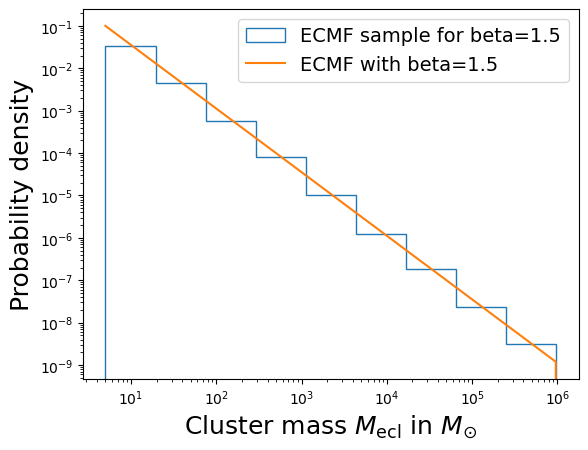

In [59]:
## Sample from a ECMF with beta=1.5
beta_model=1.5
M_over_H=0
## taking the mass drawn from the most massive cluster from the draw_ecmf_M_tot function for M_tot=1000000
## If the code is correct, the sample should have an M_tot=1000000 as well
M_1= 493205.4767414536 # Msolar

m_i_array, M_i_array, totalmass, num_clusters, kecl, beta, m_ecl_max = draw_ecmf_M_1(M_1,beta_model,SFR,M_over_H)

logbins=np.logspace(np.log10(np.min(m_i_array)),np.log10(np.max(m_i_array)), int(len(m_i_array)**(2/5)-1))
plt.hist(M_i_array, bins=logbins, density=True, label='ECMF sample for beta=1.5', histtype='step')
plt.xscale('log')
plt.yscale('log')

x=np.logspace(np.log10(5),np.log10(m_ecl_max),1000)
i=0
ECMF_can=np.array([])
while i<len(x):
    ECMF_can=np.append(ECMF_can, ECMF(x[i], kecl, 1.5, m_ecl_max)/len(M_i_array))
    i=i+1

print('The total sum of drawn clusters is:', totalmass)
print('The sample contains', len(M_i_array), 'clusters')
print('The most massive cluster has a mass of M_1 =', M_i_array[0])

print('From integrating over the ECMF, it should contain', scipy.integrate.quad(ECMF, 5, m_ecl_max, args=(kecl, 1.5, m_ecl_max))[0], 'clusters')
print(r'The ECMF slope of the sample is:',MLE_with_std(M_i_array)[0], '+/-', MLE_with_std(M_i_array)[1])
print(r'The input ECMF slope for the drawn sample is:', beta)

plt.loglog(x, ECMF_can, label='ECMF with beta=1.5')
plt.xlabel(r'Cluster mass $M_{\mathrm{ecl}}$ in $M_{\odot}$', size=18)
plt.ylabel(r'Probability density', size=18)
plt.legend(fontsize=14)

As expected, for the algorithm using the most massive cluster masses $M_1$ as input, the $M_{\mathrm{tot}}$ value, used previously to determine $M_1$, reappears.